# Comparing Markowitz Portfolio and Sig Trader with Depth 0

Context: we have a universe with $d$ stocks and we assume stationnary returns $R_t\sim N(\mu,C)$ where $\mu \in \mathbb{R}^d$ and $C\in M_d(\mathbb{R})$.

Under such assumptions, Markowitz showed that the optimal static portfolio (for the Sharpe ratio) is given by $w^* \propto C^{-1}\mu$ with $w^*\in \mathbb{R}^d$ the optimal weights to set on each stock (proportional because exact value depends on the variance threshold we set).

Given that a Sig Trader of depth 0 simply takes a static position $\ell_m \in \mathbb{R}$ for each asset $1\leq m \leq d$, we expect that upon fitting the functionals on data generated according to the random process $R_t \sim N(\mu,C)$, we should have that $\ell \propto w^*$ (provided we fit enough data).

In order to check that this hypothesis is correct, we will propose

1) arbitrary gaussian return process $R_t\sim N(\mu,C)$ using custom parameters $\mu$ and $C$

2) generate synthetic samples from this process

3) fit the depth-0 Sig Trader on these samples

4) compare the obtained functionals $\ell = (\ell_m)_{1\leq m \leq d}$ with the optimal weights $w^*=C^{-1}\mu$, hoping to find a match

### 0. Import librairies

In [1]:
import trading_strategy
import torch
import utils
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_theme()

### 1. Define some utils

In [2]:
def unif_mu(n: int, mu_min: float, mu_max: float, freq: float) -> torch.Tensor:
    """Generate n uniformly distributed mu's between mu_min and mu_max"""
    mu_annual = (mu_max - mu_min) * torch.rand(n) + mu_min
    mu_freq = mu_annual * freq
    return mu_freq

def toeplitz_cov(n: int, sigma_min: float, sigma_max: float, freq: float) -> torch.Tensor:
    """Generate a toeplitz covariance matrix with n elements and sigma_min and sigma_max"""
    sigmas_annual = (sigma_max - sigma_min) * torch.rand(n) + sigma_min
    sigmas_freq = sigmas_annual * np.sqrt(freq)
    cov = torch.zeros((n,n))
    for i in range(n):
        for j in range(i, n):
            rho = np.exp(-np.abs(i - j)/np.sqrt(n))
            cov[i,j] = rho * sigmas_freq[i] * sigmas_freq[j]
            cov[j,i] = cov[i,j]
    return cov

def generate_correlated_returns(n_points: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((n_points,))


def generate_batch_correlated_returns(batch_size: int, n_vectors: int, mu: torch.Tensor, cov: torch.Tensor) -> torch.Tensor:
    """
    Generate n_vectors of correlated returns with mean mu and covariance cov
    """
    return torch.distributions.MultivariateNormal(mu, cov).sample((batch_size, n_vectors))


def rebuild_prices(returns: torch.Tensor, initial_price: float) -> torch.Tensor:
    """
    Rebuild prices from returns
    """
    n_points, n_assets = returns.shape
    prices = torch.zeros((n_points + 1, n_assets))
    prices[0] = initial_price
    for i in range(returns.shape[0]):
        prices[i+1] = prices[i] * (1 + returns[i])
    return prices

### 2. Generate synthetic data

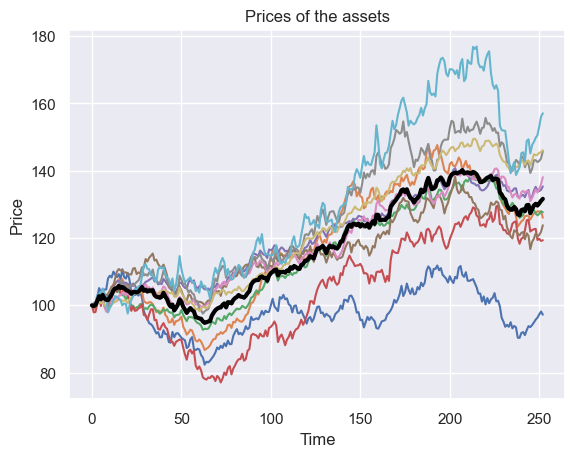

In [3]:
n_assets = 10 # number of assets we're trading
freq = 1/252 # daily data (so daily returns)

# we create synthetic data
mu_min, mu_max = 0.05, 0.3 # annual return
mu = unif_mu(n_assets, mu_min, mu_max, freq) # hourly return

sigma_min, sigma_max = 0.1, 0.3 # annual volatility
cov = toeplitz_cov(n_assets, sigma_min, sigma_max, freq) # hourly covariance

n_years = 1 # 1 year of data
n_points = int(n_years/freq) # number of points in the time series
returns = generate_correlated_returns(n_points, mu, cov)

initial_price = 100 # initial price of the assets
prices = rebuild_prices(returns, initial_price)
mean_price = torch.mean(prices, dim=1)

# let's plot the prices
plt.plot(prices)
plt.plot(mean_price, color='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Prices of the assets')
plt.show()

### 3. Fit Markowitz Portfolio (easy since we know the process)

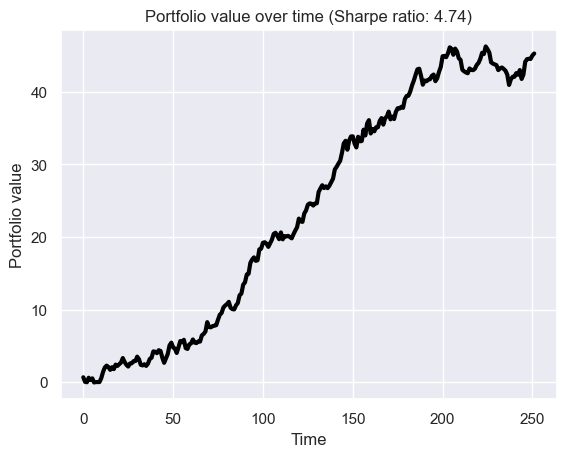

In [4]:
w = torch.inverse(cov) @ mu # optimal weights
w = w / torch.sum(w) # normalize weights

# compute returns of portfolio
portfolio_return = torch.zeros(n_points)
portfolio_pnl = torch.zeros(n_points)
for i in range(n_points):
    portfolio_return[i] = w @ returns[i, :]
    portfolio_pnl[i] = w @ (prices[i, :] * returns[i, :])

portfolio_value = torch.cumsum(portfolio_pnl, dim=0)

mean_daily_return = torch.mean(portfolio_return)
std_daily_return = torch.std(portfolio_return)
sharpe_ratio = mean_daily_return / std_daily_return * np.sqrt(1/freq)

# let's plot the portfolio value over time
plt.plot(portfolio_value, color='black', linewidth=3)
plt.xlabel('Time')
plt.ylabel('Portfolio value')
plt.title(f'Portfolio value over time (Sharpe ratio: {sharpe_ratio:.2f})')
plt.show()

## Sig Trader of order 0 should yield Markowitz

In [5]:
batch_size = 10000
batch_size = 100
initial_price = 100

batch_returns = generate_batch_correlated_returns(batch_size, n_points, mu, cov)

batch_prices = torch.zeros((batch_size, n_points + 1, n_assets))
for i in range(batch_size):
    batch_prices[i] = rebuild_prices(batch_returns[i], initial_price)

In [6]:
# Sig Trader parameters
depth = 0
delta = 1

In [7]:
# fit with only 100 samples
n_batch = 100
ts = trading_strategy.TradingStrategy(depth, delta)
info_data = torch.zeros((n_batch, n_points + 1, 0))
ts.fit(batch_prices[:n_batch], info_data[:n_batch])
ts.print_functionals()

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([-0.0103])
L_2
Level 0:
tensor([0.0214])
L_3
Level 0:
tensor([0.0261])
L_4
Level 0:
tensor([-0.0294])
L_5
Level 0:
tensor([0.0791])
L_6
Level 0:
tensor([-0.0340])
L_7
Level 0:
tensor([0.0435])
L_8
Level 0:
tensor([-0.0226])
L_9
Level 0:
tensor([0.0453])
L_10
Level 0:
tensor([-0.0043])


In [8]:
# # fit with only 100 samples
# n_batch = 1000
# ts = trading_strategy.TradingStrategy(depth, delta)
# info_data = torch.zeros((n_batch, n_points + 1, 0))
# ts.fit(batch_prices[:n_batch], info_data[:n_batch])
# ts.print_functionals()

In [9]:
# # fit with only 10000 samples
# n_batch = 10000
# ts = trading_strategy.TradingStrategy(depth, delta)
# info_data = torch.zeros((n_batch, n_points + 1, 0))
# ts.fit(batch_prices[:n_batch], info_data[:n_batch])
# ts.print_functionals()

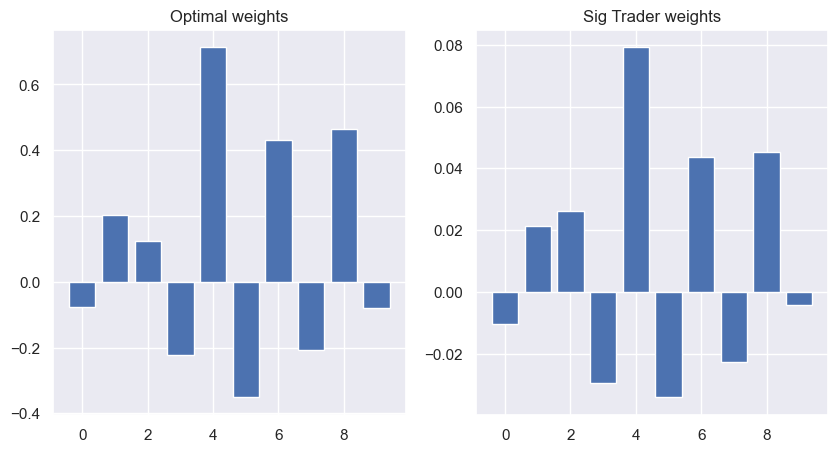

In [10]:
w_sig = [ts.functionals[i][0] for i in range(n_assets)]

# bar plot of w and w_sig
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.bar(range(n_assets), w)
plt.title('Optimal weights')
plt.subplot(1,2,2)
plt.bar(range(n_assets), w_sig)
plt.title('Sig Trader weights')
plt.show()


In [11]:
# fit with only 10000 samples
n_batch = 100
ts = trading_strategy.TradingStrategy(depth, delta)
info_data = torch.zeros((n_batch, n_points + 1, 0))
ts.fit(batch_prices[:n_batch], info_data[:n_batch])
ts.print_functionals()

mu_sig successfully computed
sigma_sig successfully computed
lambda successfully computed
Fitting successful.

L_1
Level 0:
tensor([-0.0103])
L_2
Level 0:
tensor([0.0214])
L_3
Level 0:
tensor([0.0261])
L_4
Level 0:
tensor([-0.0294])
L_5
Level 0:
tensor([0.0791])
L_6
Level 0:
tensor([-0.0340])
L_7
Level 0:
tensor([0.0435])
L_8
Level 0:
tensor([-0.0226])
L_9
Level 0:
tensor([0.0453])
L_10
Level 0:
tensor([-0.0043])


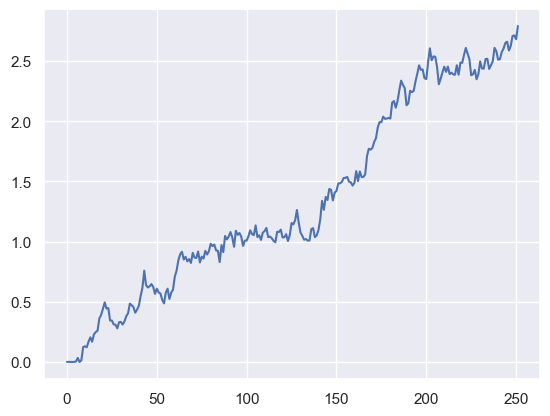

In [12]:
# let's trade
index = 0
X = batch_prices[index]
f = info_data[index]
xi = ts.trade(X, f)
daily_pnl = ts.compute_pnl(X, xi) # daily pnl on each asset
daily_global_pnl = torch.sum(daily_pnl, dim=1) # daily pnl on the portfolio
cum_global_pnl = torch.cumsum(daily_global_pnl, dim=0)

plt.figure()
plt.plot(cum_global_pnl)
plt.show()

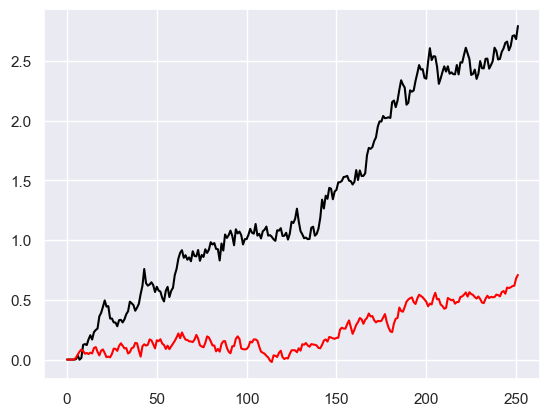

In [24]:
# let's trade
index = 0
X = batch_prices[index]
n_removed_stocks = 6
X_red = X[:,:-n_removed_stocks] # remove last 2 stocks
no_info = torch.zeros((n_points + 1, n_removed_stocks))
new_X = torch.cat((X_red, no_info), dim=1)
f = info_data[index]

new_xi = ts.trade(new_X, f)

new_daily_pnl = ts.compute_pnl(new_X, xi) # daily pnl on each asset
new_daily_global_pnl = torch.sum(new_daily_pnl, dim=1) # daily pnl on the portfolio
new_cum_global_pnl = torch.cumsum(new_daily_global_pnl, dim=0)

plt.figure()
plt.plot(cum_global_pnl, label='original', color='black')
plt.plot(new_cum_global_pnl, label='reduced', color='red')
plt.show()